In [9]:
!pip install prophet

In [24]:
# load dataset
import pandas as pd

data = pd.read_csv("C:/Users/User/Downloads/GEFCom2014E.csv")
data = data.dropna()
data.head()

,Date,Hour,load,T
17544,01-01-2006,1,3010.0,22.67
17545,01-01-2006,2,2853.0,20.67
17546,01-01-2006,3,2758.0,21.33
17547,01-01-2006,4,2705.0,19.00
17548,01-01-2006,5,2709.0,19.33


00:35:24 - cmdstanpy - INFO - Chain [1] start processing
00:35:30 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 0.04861339919793697
MAE: 163.78402589616488


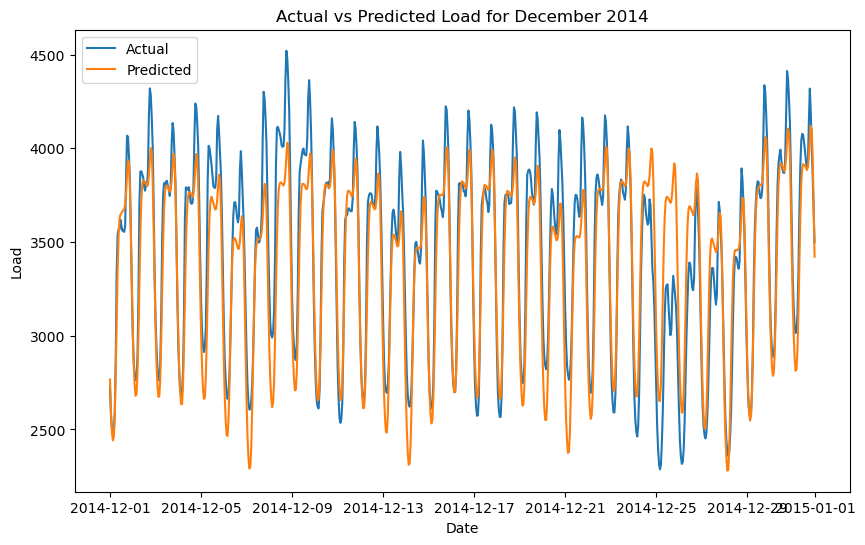

In [25]:
import pandas as pd



# Identify and correct '24:00:00' time values
data['Hour'] = data['Hour'].replace(24, 0)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Shift the '24' hour entries to the next day
data.loc[data['Hour'] == 0, 'Date'] += pd.Timedelta(days=1)

# Combine Date and Hour into a single datetime column
data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Hour'].astype(str) + ':00:00', format='%Y-%m-%d %H:%M:%S')



# Handle missing values in the temperature column
data['T'].interpolate(method='linear', inplace=True)

# Prepare the data for Prophet
data = data.rename(columns={'Datetime': 'ds', 'load': 'y'})

# Limit the training data to December 2013 to November 2014
train = data[(data['ds'] >= '2013-12-01') & (data['ds'] < '2014-12-01')]
test = data[(data['ds'] >= '2014-12-01') & (data['ds'] < '2015-01-01')]

# Train the Prophet model
model = Prophet()
model.add_regressor('T')
model.fit(train)

# Make predictions
future = model.make_future_dataframe(periods=31*24, freq='H')
future['T'] = data['T'][-len(future):].reset_index(drop=True)  # Add the temperature data to the future DataFrame
forecast = model.predict(future)

# Filter the predictions for December 2014
december_forecast = forecast[(forecast['ds'] >= '2014-12-01') & (forecast['ds'] < '2015-01-01')]

# Evaluate the model
mape = mean_absolute_percentage_error(test['y'], december_forecast['yhat'])
mae = mean_absolute_error(test['y'], december_forecast['yhat'])

print(f'MAPE: {mape}')
print(f'MAE: {mae}')

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(december_forecast['ds'], december_forecast['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual vs Predicted Load for December 2014')
plt.legend()
plt.show()

MAPE: 0.04861339919793697
MAE: 163.78402589616488
Residual Mean: 62.58118405712874


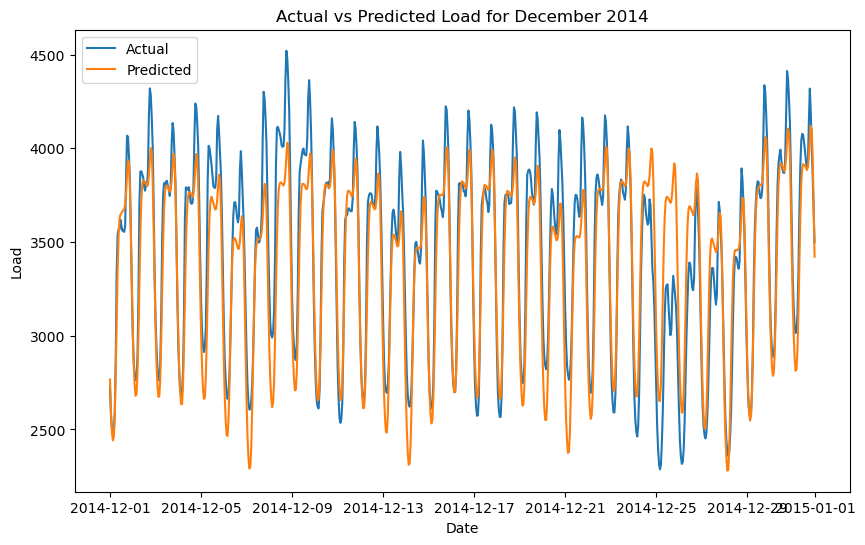

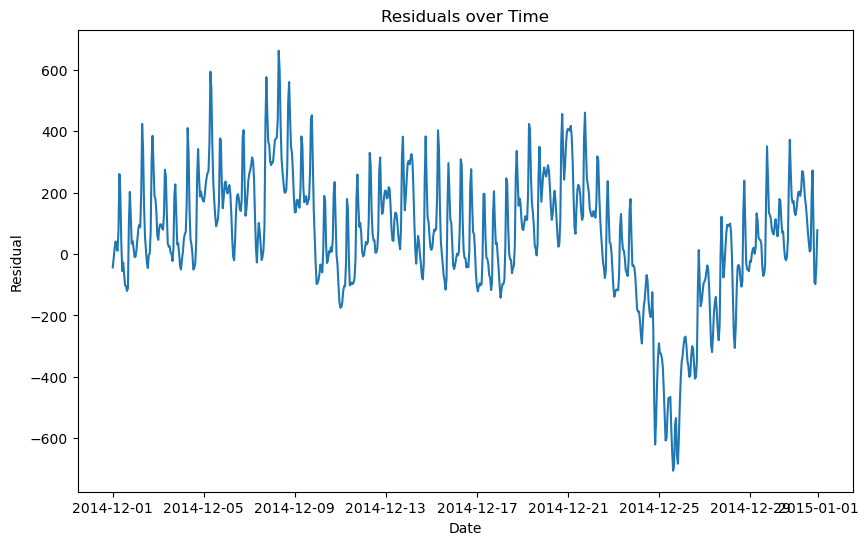

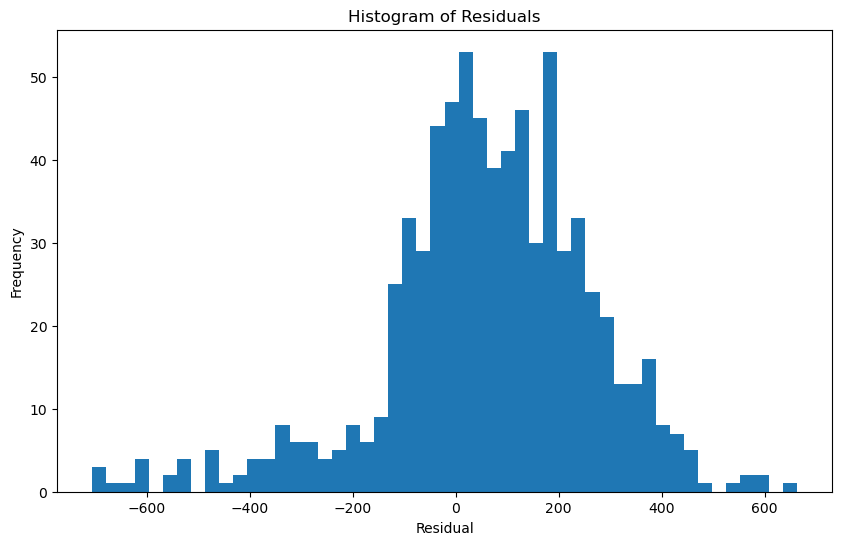

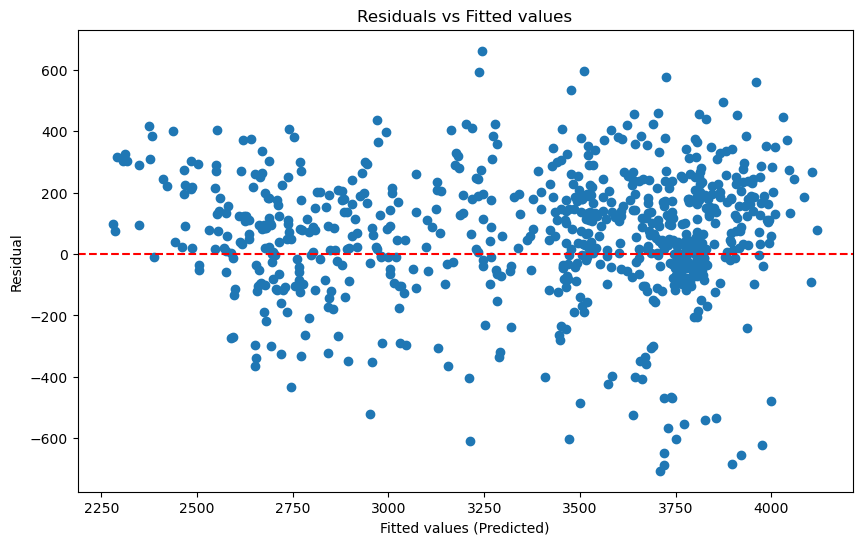

In [26]:
# Merge actual and forecast data
merged = pd.merge(test, december_forecast[['ds', 'yhat']], on='ds')
merged['residual'] = merged['y'] - merged['yhat']

# Evaluate the model
mape = mean_absolute_percentage_error(merged['y'], merged['yhat'])
mae = mean_absolute_error(merged['y'], merged['yhat'])
residual_mean = merged['residual'].mean()

print(f'MAPE: {mape}')
print(f'MAE: {mae}')
print(f'Residual Mean: {residual_mean}')

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(merged['ds'], merged['y'], label='Actual')
plt.plot(merged['ds'], merged['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Load')
plt.title('Actual vs Predicted Load for December 2014')
plt.legend()
plt.show()

# Residual diagnostics
# 1. Plot the residuals over time
plt.figure(figsize=(10, 6))
plt.plot(merged['ds'], merged['residual'])
plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Residuals over Time')
plt.show()

# 2. Plot a histogram of the residuals
plt.figure(figsize=(10, 6))
plt.hist(merged['residual'], bins=50)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# 3. Plot the residuals against the fitted values
plt.figure(figsize=(10, 6))
plt.scatter(merged['yhat'], merged['residual'])
plt.xlabel('Fitted values (Predicted)')
plt.ylabel('Residual')
plt.title('Residuals vs Fitted values')
plt.axhline(0, color='red', linestyle='--')
plt.show()